## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBB'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
3322
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-138.75552673086762|-466.80031910986287| 7.201498029832081|    118.9|BSSSBSBB| 31.9169| -87.7347|       PRCP|0.9947834590567648|0.9342896331229933|0.9342517179957289|0.8419900285299304|USC0001

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00018178| 31.9169| -87.7347|    118.9|-138.75552673086762|
|USC00015354| 31.9306| -88.4586|    106.7|-3.7763859131219206|
|USC00015121| 32.4714| -87.2314|     61.0|   636.185501202989|
|USC00017366| 32.4111| -87.0144|     44.8|  775.4661099130091|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(10)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
48,US1ALAT0002,32.4756,-86.4393,106.1,1,120.212326
87,US1ALAT0014,32.4825,-86.4854,100.3,1,90.100838
28,US1ALBR0001,31.7060,-85.6116,173.1,1,159.610525
25,US1ALCK0003,31.6447,-87.8540,75.0,2,144.936427
22,US1ALCK0004,31.6365,-87.8256,74.1,4,82.297235
38,US1ALDS0001,32.4042,-87.0546,46.0,2,88.613700
57,US1ALEL0004,32.5504,-86.3845,120.1,4,73.155438
53,US1ALEL0005,32.5422,-86.3783,100.0,2,78.183898
50,US1ALEL0010,32.4785,-86.1786,91.4,4,67.559607
55,US1ALEL0016,32.5801,-86.0938,96.0,1,19.340809


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (31.4000, 32.9000, -88.6000, -85.5000)
#32.5906| -86.2103

In [10]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

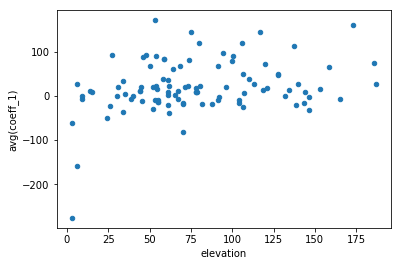

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']